# SOS Data Analysis Book

## Package Importing

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import statistics as stat
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy import stats as scipystat

## Data Cleaning

In [2]:
#Load dataset
file_path = 'UTSA Client Dataset - Students of Service (SOS).xlsx'

clients_raw = pd.read_excel(file_path, sheet_name='Clients')  #Convert dates to datetime objects

hours = (pd.read_excel(file_path, sheet_name='Service Hours') #Rename the userID column to 'Galaxy ID'
         .rename({'userId': 'Galaxy ID'}, axis=1)
)

survey_raw = pd.read_excel(file_path, sheet_name='Survey Responses')

### Clients Dataset Cleaning

The clients dataset has a few known issues that need to be taken care of before any analysis is done. Below will be the first few rows of the uncleaned data set

In [3]:
#Display the raw clients data
clients_raw.head()

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,...,Gender,Last Login,Responses,Hours,Student ID,Learn Participation 2022,Explore Participation,Make It Happen Badge (Yes/No),Trip Eligible (Yes/No),Scholarship Badge (Yes/No)
0,S00001,2315153.0,1107 Walkers Way,San Antonio,TX,78216,1979-11-07 00:00:00,2018-12-18,39,45,...,Male,2025-03-24 00:00:00,45,3876.94,Unknown,No,Yes,Yes,Yes,Yes
1,S00002,2315154.0,NaN,NaN,NaN,NaN,Unknown,2018-12-18,Unknown,Unknown,...,Male,Never,0,0.00,Unknown,No,No,No,No,No
2,S00003,2403270.0,5518 Lost Lane,San Antonio,TX,78238,1977-07-18 00:00:00,2019-01-10,41,47,...,Female,2025-03-28 00:00:00,61,539.00,Unknown,No,Yes,Yes,Yes,Yes
3,S00004,2420898.0,11110 Denae Drive,Live Oak,TX,78233,2001-08-24 00:00:00,2019-01-15,17,23,...,Male,2024-05-30 00:00:00,1,17.00,1052103,No,Yes,Yes,Yes,No
4,S00005,2420899.0,510 E Hathaway Dr,San Antonio,TX,78209,2003-08-05 00:00:00,2019-01-15,15,21,...,Male,2022-02-07 00:00:00,1,36.00,Unknown,No,No,Yes,Yes,Yes


In [4]:
clients_raw.columns

Index(['SOS ID', 'Galaxy ID', 'Street Address', 'City', 'State', 'Zip Code',
       'Date of Birth', 'dateAdded', 'Age at Sign Up', 'Age Now',
       'HS Graduation Year', 'School', 'District', 'Race/Ethnicity', 'Gender',
       'Last Login', 'Responses', 'Hours', 'Student ID',
       'Learn Participation 2022', 'Explore Participation',
       'Make It Happen Badge (Yes/No)', 'Trip Eligible (Yes/No)',
       'Scholarship Badge (Yes/No)'],
      dtype='object')

Some columns have missing values that are input as strings rather than a None object. This might cause some issues later for numeric columns, so numeric columns will have all of their missing values converted to empty objects. 

- 'HS Graduation Year' has 0 in the spot for unknown. This will still be changed to None so that it does not skew any potential calculations.
- 'Age Now' has 'Unknown' in for unknown objects. These will be changed to None.

One of the main columns we are looking at is 'Age at Sign Up'. One of our goals for this cleaning is to filter the dataset to only students as parents in this mix too. There are quite a few ages in 'Age at Sign Up' which arent valid ages.

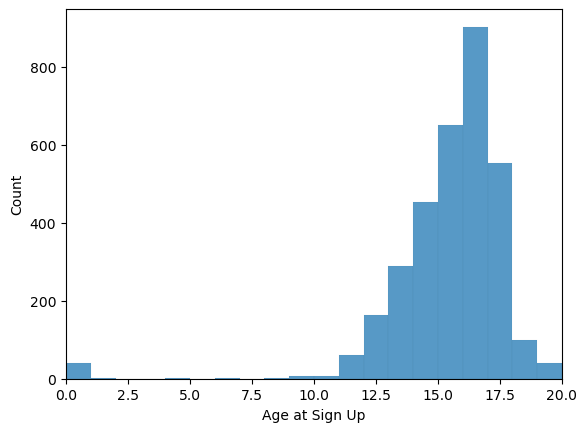

In [5]:
#Show histogram of 'Age at Sign Up' in clients_raw
sns.histplot(clients_raw[clients_raw['Age at Sign Up']!='Unknown']['Age at Sign Up'], binwidth=1)
plt.xlim(0,20)
plt.show()

As we can see, there are some values that are quite low. As per a meeting with the non-profit, ages 0-4 are presumed to be in error. The goal will be to instead of replacing these ages with None or removing them, to replace them with the median age. This will make their data usable without causing much skew.

In [6]:
#See how many clients have ages between 0 and 4
clients_raw[clients_raw['Age at Sign Up'].isin([0,1,2,3,4])]['Age at Sign Up'].value_counts()

Age at Sign Up
0    41
4     2
1     1
Name: count, dtype: int64

There are only 44 mistaken ages at sign up, so this shouldnt cause major issues in the data. The values do contain valid hours and address information, so there information would still prove useful. Using the median age would minimize impact on the data.

- Some values are input as 'Unknown', these will need to be changed.
- The values 0, 1, and 4 were discussed to likely be errors in some way.

These values will be changed to '15' as that is the median age, which will be shown below.

In [7]:
#Find the median and mean of 'Age at Sign Up'
signupage = clients_raw[clients_raw['Age at Sign Up'].isin([i for i in range(6,21)])]['Age at Sign Up']

print(f"Median: {stat.median(signupage)}\nMean: {stat.mean(signupage)}")

Median: 15
Mean: 15.22023992617656


The following is zip code information. The first section is assigning zip codes to certain counties for bexar and all the counties connected to bexar.

Then, 2 dataframes are made with family income information. The first is information for zip code based family income. This list does not cover all the target zip codes, so if a zip code is does not have its specific income information available then the income information will be pulled based on the county.

This income information was gotten from the [American Community Survey 2023 5-Year Estimates](https://data.census.gov/table/ACSST5Y2023.S1901?q=median+income+by+county).

In [8]:
#Zip code lists for county assignemnts

bexar_zips = [78245,78254,78249,78253,78251,
78228,78250,78240,78247,78207,
78223,78258,78201,78227,78230,
78233,78213,78221,78216,
78109,78209,78244,78237,
78218,78232,78260,78210,78023,
78229,78217,78242,78239,78211,
78238,78212,78222,78259,78261,
78148,78214,78224,78015,78219,
78220,78255,78248,78264,
78252,78225,78204,78256,
78073,78202,78112,78231,
78236,78002,78226,78203,
78257,78263,78208,
78215,78152,78234,78205,78235,
78243,78206,78262,78275,78286,
78287,78054,78150,78241,78246,
78265,78268,78270,78269,78278,
78280,78279,78284,78283,78285,
78288,78291,78289,78293,78292,
78295,78294,78297,78296,78299,
78298]

kendall_zips = [78006,78013,78606,78004,78027,78074]

bandera_zips = [78063,78003,78055,78884,78885,78883]

comal_zips = [78130,78132,78133,78070,78163,78266,78623,78131,78135]

guadalupe_zips = [78666,78155,78108,78154,78648,78124,78655,78638,78123,78670,78115,78156]

wilson_zips = [78114,78121,78101,78160,78140,78113,78161,78147,78143]

atascosa_zips = [78064,78065,78026,78052,78069,78011,78008,78050,78062,78012]

medina_zips = [78861,78016,78009,78059,78039,78056,78057,78850,78066,78886]

county_zips = {
    'Bexar': bexar_zips,
    'Kendall': kendall_zips,
    'Bandera': bandera_zips,
    'Comal': comal_zips,
    'Guadalupe': guadalupe_zips,
    'Wilson': wilson_zips,
    'Atascosa': atascosa_zips,
    'Medina': medina_zips
}

all_zips = []

for key in county_zips:
    for i in county_zips[key]:
        all_zips.append(i)

zips_for_incomes = [78002, 78003, 78004, 78006, 78008, 78009, 
                    78011, 78012, 78013, 78015, 78016, 78023, 
                    78026, 78027, 78039, 78050, 78052, 78055, 
                    78056, 78057, 78059, 78062, 78063, 78064, 
                    78065, 78066, 78069, 78070, 78073, 78074, 
                    78101, 78108, 78109, 78112, 78113, 78114, 
                    78121, 78123, 78124, 78130, 78132, 78133, 
                    78140, 78143, 78147, 78148, 78150, 78152, 
                    78154, 78155, 78160, 78161, 78163, 78201, 
                    78202, 78203, 78204, 78205, 78207, 78208, 
                    78209, 78210, 78211, 78212, 78213, 78214, 
                    78215, 78216, 78217, 78218, 78219, 78220, 
                    78221, 78222, 78223, 78224, 78225, 78226, 
                    78227, 78228, 78229, 78230, 78231, 78232, 
                    78233, 78234, 78235, 78236, 78237, 78238, 
                    78239, 78240, 78242, 78243, 78244, 78245, 
                    78247, 78248, 78249, 78250, 78251, 78252, 
                    78253, 78254, 78255, 78256, 78257, 78258, 
                    78259, 78260, 78261, 78263, 78264, 78266, 
                    78606, 78623, 78638, 78648, 78655, 78666, 
                    78670, 78850, 78861, 78883, 78884, 78885, 78886]

zip_income_list = ['64082', '54500', '160147', '110955', '-', 
                    '102724', '29089', '47708', '79770', '155488', 
                    '57609', '129701', '77257', '108434', '74013', 
                    '91212', '69018', '71635', '122026', '63967', 
                    '72254', '-', '79066', '69407', '63653', 
                    '92813', '71071', '115076', '65342', '-', 
                    '90413', '117304', '87635', '54445', '90191', 
                    '84260', '126726', '95700', '82534', '84426', 
                    '126934', '80777', '49032', '-', '72961', 
                    '75395', '-', '102212', '97465', '71367', 
                    '62188', '75966', '133681', '46129', '43708', 
                    '34815', '54667', '34631', '30655', '23194', 
                    '84180', '51990', '54279', '60222', '53342', 
                    '41334', '82128', '55488', '56852', '56833', 
                    '52147', '41244', '63114', '64251', '50352', 
                    '57965', '46829', '32340', '48049', '50865', 
                    '46718', '71564', '103538', '84633', '73729', 
                    '100096', '64919', '96771', '40233', '56227', 
                    '71455', '62203', '48979', '-', '67789', 
                    '87890', '89184', '130605', '80851', '80289', 
                    '78025', '79635', '104260', '115823', '151673', 
                    '72797', '74540', '116133', '109429', '150705', 
                    '140120', '81793', '60245', '132470', '89980', 
                    '122143', '82760', '56533', '48409', '55478', 
                    '76591', '77344', '64491', '36189', '82292', '70833', '119276']

zip_incomes_withblanks = pd.DataFrame(data={'Zip Code': zips_for_incomes, 'Median Income': zip_income_list})

zip_incomes = zip_incomes_withblanks[zip_incomes_withblanks['Median Income'] != '-']

county_incomes = pd.DataFrame(data={'County': ['Kendall','Bandera','Comal','Guadalupe','Wilson','Atascosa','Medina', 'Bexar'],
                                     'Median Income':[110498,69073,99193,95953,92461,69413,73462,69807]})


yes_no_cols = ['Learn Participation 2022', 
               'Explore Participation',
               'Make It Happen Badge (Yes/No)', 
               'Trip Eligible (Yes/No)',
               'Scholarship Badge (Yes/No)']

schools_with_clubs = ['Brackenridge High School','Whittier Middle School', 'Driscoll Middle school', 'Advanced Learning Academy', 
                      "Young Women's Leadership Academy", 'CAST Med High School', 'International School of the Americas', 'South San High School', 
                      'Churchill High School', 'Johnson High School', 'CAST Tech High School' , 'IDEA Converse', 'RISE Inspire Academy', 
                      'Nimitz Middle School', 'Thomas Jefferson High School', "Young Men's Leadership Academy", 'Southside High School']

general_agg_stats = {'Galaxy ID': 'count',
            'Age at Sign Up': ['mean', 'median', 'min', 'max'],
            'Service Range': 'mean',
            'Hours': ['sum', 'mean'],
            'Follow Through': ['sum', 'mean'],
            'Trip Eligible (Yes/No)': ['sum', 'mean'],
            'Service Count': ['mean', 'sum'],
            'Responses' : ['mean', 'sum'],
            'Make It Happen Badge (Yes/No)': ['sum', 'mean'],
            'Scholarship Badge (Yes/No)': ['sum', 'mean'],
            'Explore Participation': ['sum', 'mean']}

age_agg_stats = {'Galaxy ID': 'count',
            'Service Range': 'mean',
            'Hours': ['sum', 'mean'],
            'Follow Through': ['sum', 'mean'],
            'Trip Eligible (Yes/No)': ['sum', 'mean'],
            'Service Count': ['mean', 'sum'],
            'Responses' : ['mean', 'sum'],
            'Make It Happen Badge (Yes/No)': ['sum', 'mean'],
            'Scholarship Badge (Yes/No)': ['sum', 'mean'],
            'Explore Participation': ['sum', 'mean']}

In [9]:
def assign_zipincome(zip):
    if zip in zip_incomes['Zip Code'].values:
        return round((int(zip_incomes[zip_incomes['Zip Code']==zip]['Median Income'].values[0])))
    
def assign_countyincome(county):
    if county in county_incomes['County'].values:
        return round(int(county_incomes[county_incomes['County']==county]['Median Income'].values[0]))

In [10]:
int(zip_incomes[zip_incomes['Zip Code']==78240]['Median Income'].values[0])

62203

With only the students in the valid age range being considered, both the mean and the median age are 15. This also shows that our ages should be roughly normally distributed as the values are close to each other.

As well as replacing these ages with 15, the other cleaning is as follows.

- All rows with missing galaxy IDs will be removed. These rows are also missing most of their other data making them not useful to this analysis. The galaxy ID is also used as a link between sheets and student tracking, so without this information that row is not of much use.

- All adults will be filtered out. This will go off of the age at sign up. Anyone over the age of 20 at sign up will be removed. This cut off was gotten through talks with the non-profit.

- Any data before 2020 will be removed from the cleaned set. This data is very inconsistent and often is missing alot of data. This data also has odd data points and potential errors. Nearly all data past this point is filled out accurately and will give a better analysis.

- Some zip codes include a 4 digit code in addition to the typical 5 digit zip. The information is unnecessary to this analysis and all zip codes will be truncated to 5 digits

There will also be new columns added to take in information from the hours sheet

- **'Collected Hours'** will be the hours that the client accrued from January 1, 2020 onwards.
- **'Earliest Service'** will show the students first service starting at January 1, 2020.
- **'Latest Service'** will show the students latest service
- **'Service Count'** will be how many events the students has participated in.
- **'Service Range'** is the time in days between the lastest service and the ealiest service, showing how long they were/have been active
- **'Follow Through'** is a 1/0 variable where 1 means the clients actually volunteered after signing up, 0 means they signed up but never volunteered.
- **'County'** is the county gotten from the given zip code, using the lists above

In [21]:

clients = (clients_raw[clients_raw['Galaxy ID'].notna()]
                        .replace({'HS Graduation Year': '0', 'Age Now': 'Unknown'}, None)
                        .replace({'Age at Sign Up': {"Unknown": 15, 0: 15, 1: 15, 4: 15}})
                        .query('`Age at Sign Up` <= 20')
[clients_raw['dateAdded'] >= dt.datetime(2020, 1, 1)]
)

# Apply data transformations
clients[yes_no_cols] = clients[yes_no_cols].replace({'Yes': 1, 'No': 0})
clients['Zip Code'] = pd.to_numeric(clients['Zip Code'].astype(str).str[:5])

# Recalculate derived columns
hours_sum = hours.groupby('Galaxy ID')['hours'].sum()
clients['Collected Hours'] = clients['Galaxy ID'].map(hours_sum)

earliest_service = hours.groupby('Galaxy ID')['Event Date'].min()
clients['Earliest Service'] = clients['Galaxy ID'].map(earliest_service)

latest_service = hours.groupby('Galaxy ID')['Event Date'].max()
clients['Latest Service'] = clients['Galaxy ID'].map(latest_service)

service_count = hours.groupby('Galaxy ID')['Event Date'].count()
clients['Service Count'] = clients['Galaxy ID'].map(service_count)

range_mask = (clients['Latest Service'] - clients['Earliest Service']).dt.days > 0
clients.loc[range_mask, 'Service Range'] = clients['Latest Service'] - clients['Earliest Service']

clients['Follow Through'] = np.where(clients['Hours'] > 0, 1, 0).astype(int)
clients['Club'] = np.where(clients['School'].isin(schools_with_clubs), 1, 0).astype(int)

# Assign counties
def county_assign(zip_code):
    for county, zips in county_zips.items():
        if zip_code in zips:
            return county
    return None

clients['County'] = clients['Zip Code'].apply(county_assign)

# Assign incomes
def assign_zipincome(zip_code):
    if zip_code in zip_incomes['Zip Code'].values:
        return round(int(zip_incomes[zip_incomes['Zip Code'] == zip_code]['Median Income'].values[0]))
    return None

def assign_countyincome(county):
    if county in county_incomes['County'].values:
        return round(int(county_incomes[county_incomes['County'] == county]['Median Income'].values[0]))
    return None

for idx, row in clients.iterrows():
    zip_of_id = row['Zip Code']
    county_of_id = row['County']
    
    if zip_of_id in zip_incomes['Zip Code'].values:
        clients.loc[idx, 'Median Family Income'] = assign_zipincome(zip_of_id)
    elif county_of_id in county_incomes['County'].values:
        clients.loc[idx, 'Median Family Income'] = assign_countyincome(county_of_id)
    else:
        clients.loc[idx, 'Median Family Income'] = None

clients['Median Family Income'] = clients['Median Family Income'].astype('Int64')

# Create income range function
def income_range(income):
    if pd.isnull(income):
        return None
    range_string = f'{int(str(income)[:-6])}0 - {int(str(income)[:-6])}9'
    return range_string

clients['Income Range (Thousands)'] = clients['Median Family Income'].apply(income_range)

def step_assign(id):
    if clients.loc[clients['Galaxy ID']==id, 'Explore Participation'].values[0] == 1:
        return 5
    elif (clients.loc[clients['Galaxy ID']==id, 'Explore Participation'].values[0] == 0)&(clients.loc[clients['Galaxy ID']==id, 'Trip Eligible (Yes/No)'].values[0] == 1):
        return 4
    elif clients.loc[clients['Galaxy ID']==id, 'Follow Through'].values[0] == 1:
        return 3
    elif (clients.loc[clients['Galaxy ID']==id, 'Responses'].values[0] > 0)&(clients.loc[clients['Galaxy ID']==id, 'Hours'].values[0] == 0):
        return 2
    else:
        return 1
    
clients['Step'] = clients['Galaxy ID'].apply(step_assign)

funnel_dict = pd.DataFrame(data={ 'Step' : ['1','2','3','4','5'], 
                                 'Count' : [len(clients[clients['Step'].isin([1,2,3,4,5])]), 
                                            len(clients[clients['Step'].isin([2,3,4,5])]), 
                                            len(clients[clients['Step'].isin([3,4,5])]), 
                                            len(clients[clients['Step'].isin([4,5])]), 
                                            len(clients[clients['Step'].isin([5])])]})

# Create school club data
schoolclub_hours = clients.groupby(by='School').agg({'Hours': 'sum'}).reset_index()
schoolclub_hours['Club'] = np.where(schoolclub_hours['School'].isin(schools_with_clubs), 1, 0).astype(str)

# Update quarter data after assigning year
hours['year'] = hours['Event Date'].dt.year

hours['month'] = hours['Event Date'].dt.month

hours['qtr-year'] = (
    hours['year'].astype(str) +
    '-Q' + hours['Event Date'].dt.quarter.astype(str)
)

hours['mon-year'] = (
        hours['year'].astype(str) +
    '-' + hours['month'].astype(str)
)

qtr_vol_counts = pd.DataFrame(
    list(hours.groupby('qtr-year')['Galaxy ID'].nunique().to_dict().items()),
    columns=['QTR', 'Active Volunteers']
)

C:\Users\cln87\AppData\Local\Temp\ipykernel_13600\463478328.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\cln87\AppData\Local\Temp\ipykernel_13600\463478328.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\cln87\AppData\Local\Temp\ipykernel_13600\463478328.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [22]:
hours

,Galaxy ID,zipCodeNeed,needName,hours,Event Date,agency,year,qtr-year,month,mon-year
0,2421117,NaN,NaN,3.0,2018-01-03,NaN,2018,2018-Q1,1,2018-1
1,2421117,NaN,NaN,3.0,2018-01-04,NaN,2018,2018-Q1,1,2018-1
2,2421065,NaN,NaN,4.0,2018-01-05,NaN,2018,2018-Q1,1,2018-1
3,2421065,NaN,NaN,2.0,2018-01-08,NaN,2018,2018-Q1,1,2018-1
4,2421541,NaN,NaN,1.0,2018-01-13,NaN,2018,2018-Q1,1,2018-1
...,...,...,...,...,...,...,...,...,...,...
7577,5907067,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7578,4418385,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7579,6574945,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7580,5933094,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3


In [12]:
clients[(clients['Responses']==0)&(clients['Hours']>0)]

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,...,Earliest Service,Latest Service,Service Count,Service Range,Follow Through,Club,County,Median Family Income,Income Range (Thousands),Step
1449,S01664,3353389.0,105 San Arturo St,San Antonio,TX,78210,2005-02-21 00:00:00,2020-05-23,15,20,...,2020-06-05,2020-06-12,2.0,7 days,1,1,Bexar,51990,50 - 59,3
1451,S01667,3362218.0,5419 Cervantes,San Antonio,TX,78228,2005-08-31 00:00:00,2020-05-30,14,19,...,2020-05-30,2020-07-09,38.0,40 days,1,1,Bexar,50865,50 - 59,4
1852,S02089,4294450.0,8015 maddie lane,san antonio,TX,78255,2004-09-02 00:00:00,2021-05-27,16,20,...,2021-08-02,2021-08-05,4.0,3 days,1,0,Bexar,151673,150 - 159,4
2364,S02630,5139702.0,18050 Muir Glen Drive,San Antonio,TX,78257,2005-10-21 00:00:00,2022-05-04,16,19,...,2022-08-09,2022-08-10,2.0,1 days,1,0,Bexar,74540,70 - 79,3
2486,S02759,5440751.0,1706 wind river,san antonio,TX,78258,2008-06-06 00:00:00,2022-09-04,14,16,...,2023-11-14,2023-11-14,1.0,NaT,1,0,Bexar,116133,110 - 119,3
2555,S02832,5552914.0,24018 Alpine Lodge,San Antonio,TX,78258,2006-06-12 00:00:00,2022-09-29,16,18,...,2023-11-14,2023-11-14,1.0,NaT,1,0,Bexar,116133,110 - 119,3
2556,S02833,5552916.0,3331 Gazelle Range,San antonio,TX,78259,2007-05-23 00:00:00,2022-09-29,15,17,...,2023-11-14,2023-11-14,1.0,NaT,1,0,Bexar,109429,100 - 109,3
2680,S02964,5851873.0,1107 Walkers Way,San Antonio,TX,78216,2013-05-06 00:00:00,2023-01-24,9,11,...,2023-01-16,2023-01-16,1.0,NaT,1,0,Bexar,55488,50 - 59,3
2921,S03221,6204343.0,24019,san antonio,TX,78261,2009-05-06 00:00:00,2023-05-31,14,15,...,2023-11-30,2023-11-30,1.0,NaT,1,0,Bexar,140120,140 - 149,3
3612,S02915,5742024.0,3047,San Antonio,TX,78247,2011-03-03 00:00:00,2022-12-05,11,14,...,2022-12-05,2022-12-05,1.0,NaT,1,0,Bexar,89184,80 - 89,3


In [13]:
clients[clients['Follow Through']==1]

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,...,Earliest Service,Latest Service,Service Count,Service Range,Follow Through,Club,County,Median Family Income,Income Range (Thousands),Step
5,S02646,5143417.0,11319 Carmen Heights,San Antonio,TX,78230,2005-09-11 00:00:00,2022-05-05,16,19,...,2022-09-24,2022-09-24,1.0,NaT,1,0,Bexar,71564,70 - 79,3
9,S03962,7218008.0,6003 MacGregor Way,SAN ANTONIO,TX,78240,2007-12-16 00:00:00,2024-05-28,16,17,...,2024-12-07,2024-12-07,1.0,NaT,1,0,Bexar,62203,60 - 69,3
78,S03210,6194196.0,4422 Manitou bay,san Antonio,TX,78259,2009-05-14 00:00:00,2023-05-25,14,15,...,2023-11-30,2023-11-30,1.0,NaT,1,0,Bexar,109429,100 - 109,3
95,S01985,3923745.0,3110 Hillcrest Dr. Apt. 112,San Antonio,TX,78201,2004-11-03 00:00:00,2021-03-12,16,20,...,2021-08-21,2022-08-09,2.0,353 days,1,1,Bexar,46129,40 - 49,3
123,S02522,4926927.0,21303 Encino Commons Apt. 211,San Antonio,TX,78259,2007-11-30 00:00:00,2022-02-17,14,17,...,2023-11-30,2024-10-12,4.0,317 days,1,0,Bexar,109429,100 - 109,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,S02723,7965136.0,3947 Alamar Cottage,San Antonio,TX,78259,2009-08-31 00:00:00,2024-12-17,15,15,...,2024-12-10,2025-03-01,9.0,81 days,1,0,Bexar,109429,100 - 109,3
4503,S02729,7980540.0,6531 Jade Meadow,San Antonio,TX,78249,2010-04-26 00:00:00,2024-12-22,14,14,...,2025-01-11,2025-01-11,1.0,NaT,1,0,Bexar,80851,80 - 89,3
4512,S02739,8073608.0,218 Flintstone Lane,Universal City,TX,78148,2005-03-14 00:00:00,2025-01-30,19,20,...,2025-02-08,2025-02-08,1.0,NaT,1,0,Bexar,75395,70 - 79,3
4580,S02808,8162839.0,20614 stone oak pkwy,SAN antonio,TX,78258,2010-12-04 00:00:00,2025-03-04,14,14,...,2025-03-08,2025-03-08,1.0,NaT,1,0,Bexar,116133,110 - 119,3


In [14]:
funnel_df = pd.DataFrame(data={ 'Step' : ['1','2','3','4','5'], 'Count' : [len(clients[clients['Step'].isin([1,2,3,4,5])]), len(clients[clients['Step'].isin([2,3,4,5])]), len(clients[clients['Step'].isin([3,4,5])]), len(clients[clients['Step'].isin([4,5])]), len(clients[clients['Step'].isin([5])])]})

In [15]:
funnel_df['Step'] = funnel_df['Step'].map({'1':'Registered',
                         '2':'Responded',
                         '3':'Volunteered',
                         '4':'Explore Eligible',
                         '5':'Participated in Explore'})


In [16]:
px.funnel(funnel_df, y='Step', x='Count', title='Student Volunteers at each Stage')

In [17]:
import plotly.express as px
import plotly.graph_objects as go

# Define your brand colors
primary_colors = {
    'blue': '#2A8EC1',
    'gold': '#C1A351', 
    'dark': '#241D21',
    'light_gray': '#DFE6E8'
}

secondary_colors = {
    'dark_blue': '#0E4573',
    'light_gold': '#DBCFA3',
    'gray': '#646061',
    'green': '#7C946C'
}
# Alternative: More customized version with go.Funnel for additional control
fig_custom = go.Figure()

# Assuming your data has these columns - adjust as needed
steps = funnel_df['Step'].tolist()
counts = funnel_df['Count'].tolist()

fig_custom.add_trace(go.Funnel(
    y=steps,
    x=counts,
    textinfo="label+value+percent initial",
    textfont=dict(size=16, color='white'),
    marker=dict(
        color=funnel_colors[:len(steps)],
        line=dict(color=primary_colors['dark'], width=2)
    ),
    connector=dict(
        line=dict(color=secondary_colors['gray'], width=3)
    )
))

fig_custom.update_layout(
    title={
        'text': 'Student Volunteers at each Stage',
        'x': 0.5,
        'xanchor': 'center',
        'font': {3
                 
            'size': 24,
            'color': primary_colors['dark'],
            'family': 'Arial, sans-serif'
        }
    },
    paper_bgcolor=primary_colors['light_gray'],
    plot_bgcolor='white',
    font={
        'color': primary_colors['dark'],
        'size': 14,
        'family': 'Arial, sans-serif'
    },
    margin=dict(l=50, r=50, t=80, b=50),
    height=600,
    showlegend=False
)

# Display the custom version
fig_custom.show()

# Optional: Save the chart
# fig.write_html("student_volunteers_funnel.html")
# fig.write_image("student_volunteers_funnel.png", width=1200, height=600, scale=2)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1079599497.py, line 44)

In [ ]:
clients[clients['Service Range'].notna()]['Service Range']

95     353 days
123    317 days
162     30 days
217    124 days
276    121 days
         ...   
4447    71 days
4467    21 days
4473    28 days
4481    75 days
4497    81 days
Name: Service Range, Length: 375, dtype: timedelta64[ns]

In [ ]:
clients['Age at Sign Up'].unique()

array([16, 17, 15, 14, 18, 12, 13, 11, 10, 19, 20,  9], dtype=int64)

In [ ]:
def popstat_dashtable(popstat):
    agg_stat, flat_stat = population_stat(clients, popstat)
    agg_stat.reset_index().sort_values(by=popstat)

In [ ]:
double_hist = px.histogram(clients, x='Hours', color='Club', barmode='overlay', opacity=0.5, nbinsx=20)
double_hist.show()

TypeError: histogram() got an unexpected keyword argument 'nbinsx'

In [ ]:
tstat, p_value = scipystat.ttest_ind(clients[clients['Club']==1]['Hours'],clients[clients['Club']==0]['Hours'], equal_var=False, alternative='greater')

print(f'{tstat} {p_value}')
print(f'Confidence: {(1-round(p_value,4))*100}%')

1.5808158956387544 0.057223126103613846
Confidence: 94.28%


In [ ]:
stat.mean(clients[clients['Club']==1]['Hours'])

4.03876953125

In [ ]:
stat.variance(clients[clients['Club']==1]['Hours'])

283.7134256845493

In [ ]:
clients[clients['Club']==1]['Hours'].count()

512

In [ ]:
stat.mean(clients[clients['Club']==0]['Hours'])

2.8127824074074073

In [ ]:
stat.variance(clients[clients['Club']==0]['Hours'])

102.24500249084367

In [ ]:
clients[clients['Club']==0]['Hours'].count()

2160

In [ ]:
px.line(month_vol_counts, y='Active Volunteers')

In [ ]:
px.line(month_vol_counts[month_vol_counts['Month']<dt.date(2024,1,1)], y='Active Volunteers')

In [ ]:
month_vol_counts[month_vol_counts['Month']<dt.date(2024,5,1)]

,Month,Active Volunteers
0,2020-02-01,3
1,2020-03-01,6
2,2020-04-01,5
3,2020-05-01,5
4,2020-06-01,8
5,2020-07-01,9
6,2020-08-01,10
7,2020-09-01,9
8,2020-10-01,9
9,2020-11-01,18


In [ ]:
pd.set_option('display.max_columns', None)  #Show all columns in the DataFrame
print(len(clients), 'total clients under 21 after January 1, 2020')

2672 total clients under 21 after January 1, 2020


### Population Dataframe Creations


In [ ]:
def population_stat(df, col):
    """
    This function will create two dataframes based around the specific column provided.
    It will group the data in the specified column and return an Agg dataframe with multilevel columns and a flat dataframe with standard single-level columns
    
    Parameters:
    df: Dataframe (This should formatted specifically like the clients DataFrame)
    col: str (Columnn name to get population statistics for)

    Example:
    zip_agg, zip_flat = population_stat(clients, 'Zip Code')
    """
    #Define columns and stats to get for each one while aggregating the target dataframe by target column
    if col != 'Age at Sign Up': 
        agg_name = df.groupby(by=col).agg(
            {'Galaxy ID': 'count',
            'Age at Sign Up': ['mean', 'median', 'min', 'max'],
            'Service Range': 'mean',
            'Hours': ['sum', 'mean'],
            'Follow Through': ['sum', 'mean'],
            'Trip Eligible (Yes/No)': ['sum', 'mean'],
            'Service Count': ['mean', 'sum'],
            'Responses' : ['mean', 'sum'],
            'Make It Happen Badge (Yes/No)': ['sum', 'mean'],
            'Scholarship Badge (Yes/No)': ['sum', 'mean'],
            'Explore Participation': ['sum', 'mean'],}
        )

    if col == 'Age at Sign Up': 
        agg_name = df.groupby(by=col).agg(
            {'Galaxy ID': 'count',
            'Service Range': 'mean',
            'Hours': ['sum', 'mean'],
            'Follow Through': ['sum', 'mean'],
            'Trip Eligible (Yes/No)': ['sum', 'mean'],
            'Service Count': ['mean', 'sum'],
            'Responses' : ['mean', 'sum'],
            'Make It Happen Badge (Yes/No)': ['sum', 'mean'],
            'Scholarship Badge (Yes/No)': ['sum', 'mean'],
            'Explore Participation': ['sum', 'mean'],}
        )

    #Make service range stat more readable by only including days
    agg_name['Service Range'] = agg_name['Service Range','mean'].dt.days

    #Sort by frequency in dataframe and round all numbers to 2 decimal places
    agg_name.sort_values(by=('Galaxy ID', 'count'), ascending=False, inplace=True)
    agg_name = agg_name.round(2)

    #Create a flat dataframe that has no super headers for ease of calling
    flat_name = agg_name.copy()
    flat_name.columns = ['_'.join(col).strip() for col in flat_name.columns.values]
    flat_name.rename(columns={'Zip Code_': 'Zip Code'}, inplace=True)
    flat_name.reset_index(inplace=True)
    flat_name = flat_name.round(2)

    return agg_name, flat_name

In [ ]:
zip_groups, zipgroups_flat = population_stat(clients, 'Zip Code')

In [ ]:
district_groups, districtgroups_flat = population_stat(clients, 'District')

In [ ]:
district_groups.loc['SAISD']['Follow Through','mean']

0.24

In [ ]:
age_groups, agegroups_flat = population_stat(clients, 'Age at Sign Up')

In [ ]:
age_groups.sort_index()

Galaxy ID Age at Sign Up                Service Range    Hours  \
                   count           mean median min max          mean      sum   
Age at Sign Up                                                                  
9                      4            9.0    9.0   9   9             7     8.00   
10                     4           10.0   10.0  10  10           182    14.50   
11                    51           11.0   11.0  11  11           172   169.75   
12                   136           12.0   12.0  12  12           120   396.70   
13                   227           13.0   13.0  13  13           123  1029.60   
14                   389           14.0   14.0  14  14           127  1525.75   
15                   564           15.0   15.0  15  15           111  2080.14   
16                   714           16.0   16.0  16  16            99  2023.22   
17                   454           17.0   17.0  17  17            65   755.50   
18                    80           18.0   18.0  18  18             9    61.30   
19                    33           19.0   19.0  19  19            41    68.50   
20                    16           20.0   20.0  20  20            44    10.50   

                     Follow Through       Trip Eligible (Yes/No)        \
                mean            sum  mean                    sum  mean   
Age at Sign Up                                                           
9               2.00              2  0.50                    0.0  0.00   
10              3.62              1  0.25                    0.0  0.00   
11              3.33             21  0.41                    3.0  0.08   
12              2.92             55  0.40                    5.0  0.05   
13              4.54             73  0.32                   14.0  0.08   
14              3.92            144  0.37                   19.0  0.06   
15              3.69            168  0.30                   37.0  0.08   
16              2.83            180  0.25                   37.0  0.06   
17              1.66             75  0.17                   17.0  0.04   
18              0.77              8  0.10                    1.0  0.02   
19              2.08              7  0.21                    1.0  0.04   
20              0.66              1  0.06                    0.0  0.00   

               Service Count        Responses        \
                        mean    sum      mean   sum   
Age at Sign Up                                        
9                       1.50    3.0      1.00     4   
10                      5.00    5.0      3.75    15   
11                      2.48   52.0      1.67    85   
12                      3.07  169.0      2.90   394   
13                      3.79  277.0      2.52   573   
14                      3.69  531.0      2.77  1076   
15                      4.30  723.0      2.46  1386   
16                      3.59  647.0      1.67  1194   
17                      3.05  229.0      1.16   528   
18                      2.00   16.0      0.55    44   
19                      2.86   20.0      0.79    26   
20                      4.00    4.0      0.12     2   

               Make It Happen Badge (Yes/No)       Scholarship Badge (Yes/No)  \
                                         sum  mean                        sum   
Age at Sign Up                                                                  
9                                        0.0  0.00                        0.0   
10                                       1.0  0.33                        0.0   
11                                       3.0  0.08                        2.0   
12                                      12.0  0.11                        1.0   
13                                      17.0  0.10                       10.0   
14                                      26.0  0.08                       14.0   
15                                      44.0  0.10                       30.0   
16                                      52.0  0.09  

In [ ]:
district_groups

Galaxy ID Age at Sign Up                Service Range  \
                       count           mean median min max          mean   
District                                                                   
NEISD                    823          14.79   15.0   9  19         100.0   
SAISD                    674          15.35   16.0  10  18         107.0   
NISD                     373          15.35   16.0  11  19         134.0   
Charter                  237          14.86   15.0   9  18         101.0   
South San ISD             96          15.98   16.0  12  19         113.0   
Unknown                   85          15.82   16.0  11  20         119.0   
Private                   84          14.87   15.0   9  18         143.0   
Homeschool                62          14.71   15.0  11  19         179.0   
Judson ISD                28          16.00   16.0  14  18          75.0   
Edgewood ISD              19          16.53   17.0  14  19         284.0   
SCUC ISD                  15          15.40   16.0  13  18         147.0   
Comal ISD                 13          15.38   15.0  13  18           3.0   
Out of State              13          15.15   15.0  13  17           0.0   
Southwest ISD             11          16.00   16.0  15  17          77.0   
Southside ISD             11          16.45   16.0  15  18           NaN   
Alamo Heights ISD         10          14.40   14.5  12  17         102.0   
East Central ISD           9          15.33   16.0  13  17         133.0   
Harlandale ISD             8          13.88   13.5  11  17           NaN   
Somerset ISD               8          16.50   16.5  16  17          56.0   
Boerne ISD                 6          14.67   14.0  13  18           0.0   
Out of Area                5          16.40   17.0  13  19           NaN   
Medina Valley ISD          4          13.75   14.0  12  15           NaN   
Randolph Field ISD         2          15.50   15.5  15  16           NaN   
Poteet ISD                 2          17.00   17.0  17  17           NaN   
Jourdanton ISD             2          16.00   16.0  16  16           NaN   
SWISD                      1          15.00   15.0  15  15           NaN   
Floresville ISD            1          15.00   15.0  15  15           NaN   
Fredericksburg ISD         1          17.00   17.0  17  17           NaN   
Austin ISD                 1          15.00   15.0  15  15           NaN   
Ft Sam Houston ISD         1          12.00   12.0  12  12           0.0   
Navarro ISD                1          14.00   14.0  14  14           0.0   
Comfort ISD                1          17.00   17.0  17  17           NaN   
New Braunfels ISD          1          17.00   17.0  17  17           NaN   
Online                     1          17.00   17.0  17  17           NaN   

                      Hours       Follow Through       Trip Eligible (Yes/No)  \
                        sum  mean            sum  mean                    sum   
District                                                                        
NEISD               2702.50  3.28            318  0.39                   35.0   
SAISD               2168.86  3.22            160  0.24                   31.0   
NISD                1275.50  3.42            108  0.29                   27.0   
Charter              612.75  2.59             51  0.22                    8.0   
South San ISD        183.00  1.91             14  0.15                    4.0   
Unknown              177.50  2.09             16  0.19                    6.0   
Private              283.25  3.37             19  0.23                    8.0   
Homeschool           231.05  3.73             11  0.18                    4.0   
Judson ISD            56.30  2.01              4  0.14                    2.0   
Edgewood ISD           9.00  0.47              1  0.05                    0.0   
SCUC ISD             137.00  9.13              5  0.33                    4.0   
Comal ISD              8.00  0.62              2  0.15                  

In [ ]:
test_cat = 'Follow Through'
test_stat = 'mean'
test_search_list = []
test_search_list.append(test_cat)
test_search_list.append(test_stat)

district_groups.loc['SAISD'][test_cat, test_stat]

0.24

In [ ]:
pd.DataFrame(district_groups.loc['SAISD'])

SAISD
Galaxy ID                     count    674.00
Age at Sign Up                mean      15.35
                              median    16.00
                              min       10.00
                              max       18.00
Service Range                 mean     107.00
Hours                         sum     2168.86
                              mean       3.22
Follow Through                sum      160.00
                              mean       0.24
Trip Eligible (Yes/No)        sum       31.00
                              mean       0.06
Service Count                 mean       4.64
                              sum      743.00
Responses                     mean       2.19
                              sum     1478.00
Make It Happen Badge (Yes/No) sum       44.00
                              mean       0.09
Scholarship Badge (Yes/No)    sum       22.00
                              mean       0.04
Explore Participation         sum       12.00
                              mean       0.02

In [ ]:
pd.DataFrame(clients[['District']].value_counts().sort_values(ascending=False))

,count
District,
NEISD,823
SAISD,674
NISD,373
Charter,237
South San ISD,96
Unknown,85
Private,84
Homeschool,62
Judson ISD,28


In [ ]:
pd.DataFrame(clients[clients['Follow Through']==1]['Age at Sign Up'].value_counts().sort_index())

,count
Age at Sign Up,
9,2
10,1
11,21
12,55
13,73
14,144
15,168
16,180
17,75


### Monetary Value of Volunteered Hours

In [ ]:
#Get value of hours using 31 dollars per hour then format in dollar format
def get_hours_value():
    hourly_rate=31
    return '{:,.2f}'.format(clients['Hours'].sum()*31)

print(f'${get_hours_value()}')

$252,447.26


## Clients Data Exploration

In [ ]:
#Display Clients Data
len(clients['Zip Code'].unique())

139

In [ ]:
clients.describe(include='all')

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,HS Graduation Year,School,District,Race/Ethnicity,Gender,Last Login,Responses,Hours,Student ID,Learn Participation 2022,Explore Participation,Make It Happen Badge (Yes/No),Trip Eligible (Yes/No),Scholarship Badge (Yes/No),Collected Hours,Earliest Service,Latest Service,Service Count,Service Range,Follow Through,County,Median Family Income,Income Range (Thousands)
count,2672,2.672000e+03,2671,2672,2672,2672.000000,2672,2672,2672.000000,2663.0,2671.0,2660,2609,2672,2672,2672,2672.000000,2672.000000,2670,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,735.000000,735,735,735.000000,735,2672.000000,2627,2627.0,2627
unique,2283,NaN,2573,149,11,NaN,1777,NaN,NaN,24.0,28.0,298,34,10,4,757,NaN,NaN,1938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,14
top,S02646,NaN,18979 Redland Rd,San Antonio,TX,NaN,2007-10-02 00:00:00,NaN,NaN,17.0,0.0,"Claudia Taylor ""Lady Bird"" Johnson High School",NEISD,Unknown,Female,Never,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bexar,<NA>,50 - 59
freq,2,NaN,5,2077,2657,NaN,6,NaN,NaN,443.0,1170.0,382,823,1061,1637,1148,NaN,NaN,710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2518,<NA>,509
mean,NaN,5.944669e+06,NaN,NaN,NaN,78069.163548,NaN,2023-02-01 09:53:21.197604608,15.215195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.993638,3.047702,NaN,0.015455,0.028182,0.084545,0.060909,0.042273,11.126299,2023-05-06 22:24:00.000000256,2023-08-23 11:59:01.224489728,3.640816,108 days 13:35:01.224489796,0.275075,NaN,81719.002284,NaN
min,NaN,3.097127e+06,NaN,NaN,NaN,11434.000000,NaN,2020-01-06 00:00:00,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,2020-01-11 00:00:00,2020-01-11 00:00:00,1.000000,0 days 00:00:00,0.000000,NaN,23194.0,NaN
25%,NaN,4.684171e+06,NaN,NaN,NaN,78215.750000,NaN,2021-11-02 00:00:00,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2022-01-30 00:00:00,2022-10-11 12:00:00,1.000000,0 days 00:00:00,0.000000,NaN,54279.0,NaN
50%,NaN,6.140788e+06,NaN,NaN,NaN,78233.000000,NaN,2023-05-09 00:00:00,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2023-11-30 00:00:00,2023-11-30 00:00:00,2.000000,6 days 00:00:00,0.000000,NaN,78025.0,NaN
75%,NaN,7.257327e+06,NaN,NaN,NaN,78254.000000,NaN,2024-06-13 00:00:00,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000,2024-07-01 00:00:00,2024-11-01 00:00:00,4.000000,125 days 00:00:00,1.000000,NaN,109429.0,NaN
max,NaN,8.220827e+06,NaN,NaN,NaN,95051.000000,NaN,2025-03-27 00:00:00,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.000000,184.750000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,184.750000,2025-03-08 00:00:00,2025-03-22 00:00:00,50.000000,1739 days 00:00:00,1.000000,NaN,155488.0,NaN


In [ ]:
clients.isna().sum()

SOS ID                              0
Galaxy ID                           0
Street Address                      1
City                                0
State                               0
Zip Code                            0
Date of Birth                       0
dateAdded                           0
Age at Sign Up                      0
Age Now                             9
HS Graduation Year                  1
School                             12
District                           63
Race/Ethnicity                      0
Gender                              0
Last Login                          0
Responses                           0
Hours                               0
Student ID                          2
Learn Participation 2022          472
Explore Participation             472
Make It Happen Badge (Yes/No)     472
Trip Eligible (Yes/No)            472
Scholarship Badge (Yes/No)        472
Collected Hours                  1937
Earliest Service                 1937
Latest Servi

In [ ]:
#Find whether any duplicate Galaxy IDs exist in the dataset
client_dupgid = (clients[clients.duplicated(subset=['Galaxy ID'], keep=False)]
                 .sort_values(by='Galaxy ID'))

client_dupgid_nona = client_dupgid[client_dupgid['Galaxy ID'].notna()]

client_dupgid.head()

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,HS Graduation Year,School,District,Race/Ethnicity,Gender,Last Login,Responses,Hours,Student ID,Learn Participation 2022,Explore Participation,Make It Happen Badge (Yes/No),Trip Eligible (Yes/No),Scholarship Badge (Yes/No),Collected Hours,Earliest Service,Latest Service,Service Count,Service Range,Follow Through,County,Median Family Income,Income Range (Thousands)


In [ ]:
len(clients[clients['Gender'] == 'Female'])/len(clients)

0.6126497005988024

In [ ]:
clients.query('Gender == "Male"')

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,HS Graduation Year,School,District,Race/Ethnicity,Gender,Last Login,Responses,Hours,Student ID,Learn Participation 2022,Explore Participation,Make It Happen Badge (Yes/No),Trip Eligible (Yes/No),Scholarship Badge (Yes/No),Collected Hours,Earliest Service,Latest Service,Service Count,Service Range,Follow Through,County,Median Family Income,Income Range (Thousands)
20,S03631,6828596.0,sumantra cliff 3703,san antonio,TX,78261,2008-09-06 00:00:00,2024-01-04,15,16,2027,"Claudia Taylor ""Lady Bird"" Johnson High School",NEISD,Hispanic or Latino,Male,2024-08-26 00:00:00,2,0.0,Unknown,0.0,0.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,140120,140 - 149
35,S02872,5651347.0,19500 US Hwy 281 N,San Antonio,TX,78258,2005-02-01 00:00:00,2022-10-28,17,20,0,"Claudia Taylor ""Lady Bird"" Johnson High School",NEISD,Unknown,Male,2023-11-06 00:00:00,0,0.0,1750764,0.0,0.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,116133,110 - 119
60,S02917,5744749.0,2410 NW 36th,San Antonio,TX,78228,2007-04-25 00:00:00,2022-12-06,15,17,0,CAST Tech High School,SAISD,Unknown,Male,00:00:00,0,0.0,799351,0.0,0.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,50865,50 - 59
71,S02259,4437404.0,5146 ascot place,San Antonio,TX,78249,2004-10-24 00:00:00,2021-08-12,16,20,0,Tom C Clark High School,NISD,Unknown,Male,2021-11-27 00:00:00,0,0.0,s697677,0.0,0.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,80851,80 - 89
131,S03437,6538409.0,5743 Pin Pt,"San Antonio, TX",TX,78266,2008-10-07 00:00:00,2023-09-15,14,16,2027,"Claudia Taylor ""Lady Bird"" Johnson High School",NEISD,Multiple Races,Male,2023-11-08 00:00:00,1,1.0,1739798,0.0,0.0,0.0,0.0,0.0,1.0,2023-11-30,2023-11-30,1.0,0 days,1,Comal,132470,130 - 139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,S02824,8187394.0,203 Jardin Vis,San Antonio,TX,78258,2010-02-02 00:00:00,2025-03-14,15,15,2028,Antonian College Preparatory,Private,Multiple Races,Male,Never,0,0.0,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,0,Bexar,116133,110 - 119
4597,S02826,8191710.0,6622 Kirk Way,San Antonio,TX,78240,2013-07-04 00:00:00,2025-03-16,11,11,2031,Basis Shavano,Charter,Asian,Male,2025-03-27 00:00:00,1,0.0,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,0,Bexar,62203,60 - 69
4599,S02828,8199092.0,3678 Hidden Dr,San Antonio,TX,78217,2010-10-21 00:00:00,2025-03-19,14,14,2029,SST San Antonio College Prep High School\n,Charter,Multiple Races,Male,2025-03-26 00:00:00,1,0.0,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,0,Bexar,56852,50 - 59
4600,S02829,8201498.0,4314 Stetson Park,San Antonia,TX,78223,2009-05-03 00:00:00,2025-03-19,15,15,2027,Cast Med High School,SAISD,White,Male,Never,0,0.0,889804,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,0,Bexar,50352,50 - 59


In [ ]:
clients[clients['Explore Participation']==1]

,SOS ID,Galaxy ID,Street Address,City,State,Zip Code,Date of Birth,dateAdded,Age at Sign Up,Age Now,HS Graduation Year,School,District,Race/Ethnicity,Gender,Last Login,Responses,Hours,Student ID,Learn Participation 2022,Explore Participation,Make It Happen Badge (Yes/No),Trip Eligible (Yes/No),Scholarship Badge (Yes/No),Collected Hours,Earliest Service,Latest Service,Service Count,Service Range,Follow Through,County,Median Family Income,Income Range (Thousands)
112,S02673,5192202.0,9834 Kremmen Pl,Boerne,TX,78006,2004-03-17 00:00:00,2022-06-01,18,21,0,Samuel V. Champion High School,Boerne ISD,Unknown,Female,2022-06-06 00:00:00,0,0.0,Unknown,0.0,1.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Kendall,110955,110 - 119
162,S01689,3397003.0,3011 Northridge Dr,San Antonio,TX,78209,2005-01-28 00:00:00,2020-07-01,15,20,0,International School of the Americas,NEISD,Unknown,Female,2022-02-20 00:00:00,1,4.0,Unknown,0.0,1.0,0.0,0.0,0.0,4.0,2020-07-02,2020-08-01,2.0,30 days,1,Bexar,84180,80 - 89
559,S02588,5033729.0,515 Elmhurst Ave,San Antonio,TX,78209,2004-01-07 00:00:00,2022-04-04,18,21,0,CAST Tech High School,SAISD,Unknown,Female,2022-04-04 00:00:00,1,4.0,821871,0.0,1.0,0.0,0.0,0.0,4.0,2022-04-09,2022-04-09,1.0,0 days,1,Bexar,84180,80 - 89
1236,S03488,6580294.0,5786 white feather,San antonio,TX,78242,2006-10-16 00:00:00,2023-10-01,16,18,0,Unknown,Unknown,Unknown,Male,2025-01-01 00:00:00,0,0.0,Unknown,0.0,1.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,48979,40 - 49
1300,S01503,3114904.0,560 west Hermosa,San Antonio,TX,78212,2005-12-18 00:00:00,2020-01-14,14,19,2024,Whittier Middle School,SAISD,Hispanic or Latino,Male,2025-02-24 00:00:00,60,130.0,749555,0.0,1.0,1.0,1.0,1.0,130.0,2020-01-18,2024-10-22,28.0,1739 days,1,Bexar,60222,60 - 69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,S03532,6617920.0,11141 Moonlit Park,San Antonio,TX,78240,2006-10-02 00:00:00,2023-10-15,17,18,2025,Tom C Clark High School,NISD,Hispanic or Latino,Male,2024-01-06 00:00:00,0,0.0,733202,0.0,1.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,62203,60 - 69
3218,S03539,6632404.0,2515 Fairfield Bend Drive,San Antonio,TX,78231,2008-06-18 00:00:00,2023-10-20,15,16,2026,Cast Tech High School,SAISD,Multiple Races,Male,2024-12-18 00:00:00,10,27.0,831318,0.0,1.0,1.0,1.0,1.0,27.0,2024-02-13,2024-11-16,10.0,277 days,1,Bexar,103538,100 - 109
3291,S03619,6800061.0,3601 Storm Ridge,Schertz,TX,78108,2007-12-18 00:00:00,2023-12-18,16,17,2026,Byron P. Steele High School,SCUC ISD,Asian,Female,2025-01-24 00:00:00,18,26.5,87323,0.0,1.0,1.0,1.0,1.0,26.5,2024-02-24,2024-08-23,11.0,181 days,1,Guadalupe,117304,110 - 119
3407,S02437,4866577.0,"4848 Goldfield, Apt 175",San antonio,TX,78218,2005-10-17 00:00:00,2022-01-26,16,19,0,Roosevelt High School,NEISD,Unknown,Female,2022-03-21 00:00:00,0,0.0,954678,0.0,1.0,0.0,0.0,0.0,NaN,NaT,NaT,NaN,NaT,0,Bexar,56833,50 - 59


In [ ]:
hours.head()

,Galaxy ID,zipCodeNeed,needName,hours,Event Date,agency
0,2421117,NaN,NaN,3.0,2018-01-03,NaN
1,2421117,NaN,NaN,3.0,2018-01-04,NaN
2,2421065,NaN,NaN,4.0,2018-01-05,NaN
3,2421065,NaN,NaN,2.0,2018-01-08,NaN
4,2421541,NaN,NaN,1.0,2018-01-13,NaN


In [ ]:
locations_needing_zips = hours.drop_duplicates(subset='needName')[(hours['zipCodeNeed']==0)|(hours['zipCodeNeed'].isna())]

locations_needing_zips.to_csv('locations_needing_zips.csv')

C:\Users\cln87\AppData\Local\Temp\ipykernel_1420\4008164253.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
clients.drop()

In [ ]:
popstat_ex = 'Age at Sign Up'

def popstat_dashtable(popstat):
    agg_stat, flat_stat = population_stat(clients, popstat)
    return agg_stat.reset_index().sort_values(by=popstat)

popstat_dashtable(popstat_ex)

Age at Sign Up Galaxy ID Service Range    Hours       Follow Through        \
                      count          mean      sum  mean            sum  mean   
10              9         4             7     8.00  2.00              2  0.50   
11             10         4           182    14.50  3.62              1  0.25   
7              11        51           172   169.75  3.33             21  0.41   
5              12       136           120   396.70  2.92             55  0.40   
4              13       227           123  1029.60  4.54             73  0.32   
3              14       389           127  1525.75  3.92            144  0.37   
1              15       564           111  2080.14  3.69            168  0.30   
0              16       714            99  2023.22  2.83            180  0.25   
2              17       454            65   755.50  1.66             75  0.17   
6              18        80             9    61.30  0.77              8  0.10   
8              19        33            41    68.50  2.08              7  0.21   
9              20        16            44    10.50  0.66              1  0.06   

   Trip Eligible (Yes/No)       Service Count        Responses        \
                      sum  mean          mean    sum      mean   sum   
10                    0.0  0.00          1.50    3.0      1.00     4   
11                    0.0  0.00          5.00    5.0      3.75    15   
7                     3.0  0.08          2.48   52.0      1.67    85   
5                     5.0  0.05          3.07  169.0      2.90   394   
4                    14.0  0.08          3.79  277.0      2.52   573   
3                    19.0  0.06          3.69  531.0      2.77  1076   
1                    37.0  0.08          4.30  723.0      2.46  1386   
0                    37.0  0.06          3.59  647.0      1.67  1194   
2                    17.0  0.04          3.05  229.0      1.16   528   
6                     1.0  0.02          2.00   16.0      0.55    44   
8                     1.0  0.04          2.86   20.0      0.79    26   
9                     0.0  0.00          4.00    4.0      0.12     2   

   Make It Happen Badge (Yes/No)       Scholarship Badge (Yes/No)        \
                             sum  mean                        sum  mean   
10                           0.0  0.00                        0.0  0.00   
11                           1.0  0.33                        0.0  0.00   
7                            3.0  0.08                        2.0  0.05   
5                           12.0  0.11                        1.0  0.01   
4                           17.0  0.10                       10.0  0.06   
3                           26.0  0.08                       14.0  0.04   
1                           44.0  0.10                       30.0  0.07   
0                           52.0  0.09                       23.0  0.04   
2                           24.0  0.06                       12.0  0.03   
6                            2.0  0.03                        0.0  0.00   
8                            4.0  0.14                        1.0  0.04   
9                            1.0  0.07                        0.0  0.00   

   Explore Participation        
                     sum  mean  
10                   0.0  0.00  
11                   0.0  0.00  
7                    0.0  0.00  
5                    1.0  0.01  
4                    6.0  0.03  
3                    9.0  0.03  
1                   17.0  0.04  
0                   16.0  0.03  
2                   10.0  0.03  
6                    3.0  0.05  
8                    0.0  0.00  
9                    0.0  0.00

In [ ]:
schoolclub_hours = clients.groupby(by='School').agg({'Hours': 'sum'}).reset_index()
schoolclub_hours['Club'] = np.where(schoolclub_hours['School'].isin(schools_with_clubs), 1, 0).astype(str)

In [ ]:
schoolclub_hours

,School,Hours,Club
0,Acellus Academy,0.0,0
1,Adele C Young Intermediate School,0.0,0
2,Advanced Learning Academy,1.2,1
3,Advanced learning academy,0.0,0
4,Alamo Heights High School,88.0,0
...,...,...,...
293,rise inspire academy,20.0,0
294,south san antonio high school,0.0,0
295,travis early college high school,9.0,0
296,whittier middle school,15.5,0


In [ ]:
clients.columns

Index(['SOS ID', 'Galaxy ID', 'Street Address', 'City', 'State', 'Zip Code',
       'Date of Birth', 'dateAdded', 'Age at Sign Up', 'Age Now',
       'HS Graduation Year', 'School', 'District', 'Race/Ethnicity', 'Gender',
       'Last Login', 'Responses', 'Hours', 'Student ID',
       'Learn Participation 2022', 'Explore Participation',
       'Make It Happen Badge (Yes/No)', 'Trip Eligible (Yes/No)',
       'Scholarship Badge (Yes/No)', 'Collected Hours', 'Earliest Service',
       'Latest Service', 'Service Count', 'Service Range', 'Follow Through',
       'Club', 'County', 'Median Family Income', 'Income Range (Thousands)',
       'Step'],
      dtype='object')

In [ ]:
collected_freq_cols = ['Learn Participation 2022', 'Explore Participation', 'Make It Happen Badge (Yes/No)', 
                       'Trip Eligible (Yes/No)', 'Scholarship Badge (Yes/No)', 'Step']

notcollected_freq_cols = ['Age at Sign Up', 'Zip Code', 'School', 
                          'District', 'Race/Ethnicity', 'Gender', 
                          'Income Range (Thousands)', 'Club', 'County']

filter_populations = ['Follow Through', 'District', 'Trip Eligible(Yes/No)',
                      'Explore Participation','Make It Happen Badge (Yes/No)','Learn Participation 2022',
                      'Scholarship Badge (Yes/No)', 'Income Range (Thousands)', 'School', 'Gender']

In [ ]:
test_hours_slice = hours[hours['year']==2024]
active_galaxy = test_hours_slice['Galaxy ID']

In [ ]:
def slice_by_active(year):
    hours_slice = hours[hours['year']==year]
    active_galaxy = hours_slice['Galaxy ID'].unique()
    active_in_year = clients[clients['Galaxy ID'].isin(active_galaxy)]
    return active_in_year

In [ ]:
collected_freq_cols = ['Learn Participation 2022', 'Explore Participation', 'Make It Happen Badge (Yes/No)', 
                       'Trip Eligible (Yes/No)', 'Scholarship Badge (Yes/No)', 'Step']

notcollected_freq_cols = ['Age at Sign Up', 'Zip Code', 'School', 
                          'District', 'Race/Ethnicity', 'Gender', 
                          'Income Range (Thousands)', 'Club', 'County']

filter_populations = ['Follow Through', 'District', 'Trip Eligible(Yes/No)',
                      'Explore Participation','Make It Happen Badge (Yes/No)','Learn Participation 2022',
                      'Scholarship Badge (Yes/No)', 'Income Range (Thousands)', 'School', 'Gender']

def slice_by_active(year):
    hours_slice = hours[hours['year']==year]
    active_galaxy = hours_slice['Galaxy ID'].unique()
    active_in_year = clients[clients['Galaxy ID'].isin(active_galaxy)]
    return active_in_year

def single_var_freq(var, pop='all', pop_value=None, slice='all'):

    if slice == 'all':
        if pop == 'all':
            freq_table = pd.DataFrame(clients[var].value_counts().sort_index().reset_index())
        elif pop in filter_populations:
            freq_table = pd.DataFrame(clients[clients[pop]==pop_value][var].value_counts().sort_index().reset_index())

    elif slice in range(2020,2100):
        sliced_clients = slice_by_active(slice)
        if pop == 'all':
            freq_table = pd.DataFrame(sliced_clients[var].value_counts().sort_index().reset_index())
        elif pop in filter_populations:
            freq_table = pd.DataFrame(sliced_clients[clients[pop]==pop_value][var].value_counts().sort_index().reset_index())

    return freq_table

def multi_var_freq(var1, var2, pop='all', pop_value=None, slice='all'):

    if slice == 'all':
        if pop == 'all':
            freq_table = pd.crosstab(clients[var1], clients[var2])
        elif pop in filter_populations:
            freq_table = pd.crosstab(clients[clients[pop]==pop_value][var1], clients[clients[pop]==pop_value][var2])

    elif slice in range(2020,2100):
        sliced_clients = slice_by_active(slice)
        if pop == 'all':
            freq_table = pd.crosstab(sliced_clients[var1], sliced_clients[var2])
        elif pop in filter_populations:
            freq_table = pd.crosstab(sliced_clients[clients[pop]==pop_value][var1], sliced_clients[clients[pop]==pop_value][var2])

    return freq_table

In [ ]:
def multi_var_freq(var1, var2, pop='all', pop_value=None, slice='all'):

    if slice == 'all':
        if pop == 'all':
            freq_table = pd.crosstab(clients[var1], clients[var2])
        elif pop in filter_populations:
            freq_table = pd.crosstab(clients[clients[pop]==pop_value][var1], clients[clients[pop]==pop_value][var2])

    elif slice in range(2020,2100):
        sliced_clients = slice_by_active(slice)
        if pop == 'all':
            freq_table = pd.crosstab(sliced_clients[var1], sliced_clients[var2])
        elif pop in filter_populations:
            freq_table = pd.crosstab(sliced_clients[clients[pop]==pop_value][var1], sliced_clients[clients[pop]==pop_value][var2])

    return freq_table
       

In [ ]:
test_slice = slice_by_active(2023)
pd.crosstab(clients)

In [ ]:
multi_var_freq(var1='District', var2='Race/Ethnicity', slice=2023)

Race/Ethnicity,American Indian or Alaska Native,Asian,Black or African-American,Decline to State,Hispanic or Latino,Multiple Races,Other Race,Unknown,White
District,,,,,,,,,
Alamo Heights ISD,0,0,0,2,0,0,0,0,0
Boerne ISD,0,0,0,0,0,0,0,0,1
Charter,0,2,0,0,0,0,0,1,5
Homeschool,1,0,1,0,1,0,0,0,1
NEISD,2,15,12,6,65,10,3,25,35
NISD,0,3,0,1,9,3,0,2,2
Navarro ISD,0,0,0,0,1,0,0,0,0
Out of State,0,0,0,0,0,0,0,0,1
Private,0,0,0,0,2,2,0,0,1


In [ ]:
single_var_freq('Age at Sign Up', pop='Follow Through', pop_value=1, slice=2020)

C:\Users\cln87\AppData\Local\Temp\ipykernel_17280\2021551264.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Age at Sign Up,count
0,11,1
1,12,7
2,13,10
3,14,14
4,15,12
5,16,25
6,17,8
7,19,1


In [ ]:
pd.DataFrame(clients[clients['Follow Through']==1]['Age at Sign Up'].value_counts().sort_index())

,count
Age at Sign Up,
9,2
10,1
11,21
12,55
13,73
14,144
15,168
16,180
17,75


In [ ]:
pd.crosstab(clients['Follow Through'], clients['District'])

District,Alamo Heights ISD,Austin ISD,Boerne ISD,Charter,Comal ISD,Comfort ISD,East Central ISD,Edgewood ISD,Floresville ISD,Fredericksburg ISD,...,Private,Randolph Field ISD,SAISD,SCUC ISD,SWISD,Somerset ISD,South San ISD,Southside ISD,Southwest ISD,Unknown
Follow Through,,,,,,,,,,,,,,,,,,,,,
0,7,1,5,186,11,1,7,18,1,1,...,65,2,514,10,1,7,82,11,8,69
1,3,0,1,51,2,0,2,1,0,0,...,19,0,160,5,0,1,14,0,3,16


In [ ]:
var='Gender'

chi_base = single_var_freq(var)
chi_base['expected'] = round(( len(clients) / len(chi_base) ))
chi_base['deviation'] = ((chi_base['count'] - chi_base['expected'])**2) / chi_base['expected']

chi2 = chi_base['deviation'].sum()
dof = len(chi_base) - 1
p_val = scipystat.chi2.sf(chi2, dof)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [ ]:
def singe_var_chi(var):
    chi_base = single_var_freq(var)
    chi_base['expected'] = round(( len(clients) / len(chi_base) ))
    chi_base['deviation'] = round(((chi_base['count'] - chi_base['expected'])**2) / chi_base['expected'], 2)

    chi2 = chi_base['deviation'].sum()
    dof = len(chi_base) - 1
    p_val = scipystat.chi2.sf(chi2, dof)

    return chi_base, chi2, dof, p_val

In [ ]:
chi_df, test_chi, test_dof, test_p = singe_var_chi('Gender')

In [ ]:
chi_df

,Gender,count,expected,deviation
0,Female,1637,668,1405.63
1,Male,955,668,123.31
2,Other,27,668,615.09
3,PreferNotToSay,53,668,566.21


In [ ]:
print(test_chi, test_dof, test_p)

2710.2400000000002 3 0.0


In [ ]:
chi_base

,Age at Sign Up,count,expected
0,9,4,223
1,10,4,223
2,11,51,223
3,12,136,223
4,13,227,223
5,14,389,223
6,15,564,223
7,16,714,223
8,17,454,223
9,18,80,223


In [24]:
hours

,Galaxy ID,zipCodeNeed,needName,hours,Event Date,agency,year,qtr-year,month,mon-year
0,2421117,NaN,NaN,3.0,2018-01-03,NaN,2018,2018-Q1,1,2018-1
1,2421117,NaN,NaN,3.0,2018-01-04,NaN,2018,2018-Q1,1,2018-1
2,2421065,NaN,NaN,4.0,2018-01-05,NaN,2018,2018-Q1,1,2018-1
3,2421065,NaN,NaN,2.0,2018-01-08,NaN,2018,2018-Q1,1,2018-1
4,2421541,NaN,NaN,1.0,2018-01-13,NaN,2018,2018-Q1,1,2018-1
...,...,...,...,...,...,...,...,...,...,...
7577,5907067,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7578,4418385,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7579,6574945,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7580,5933094,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3


In [37]:
mon_vol_counts = pd.DataFrame(
    list(hours.groupby('mon-year')['Galaxy ID'].nunique().to_dict().items()),
    columns=['Month', 'Active Volunteers'])

mon_vol_counts['Month'] = pd.to_datetime(mon_vol_counts['Month'], format='%Y-%m')
mon_vol_counts = mon_vol_counts.sort_values('Month')

mon_vol_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 86
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Month              87 non-null     datetime64[ns]
 1   Active Volunteers  87 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB


In [ ]:

mon_vol_counts = pd.DataFrame(
    list(hours.groupby('mon-year')['Galaxy ID'].nunique().to_dict().items()),
    columns=['Month', 'Active Volunteers'])

mon_vol_counts['Month'] = pd.to_datetime(mon_vol_counts['Month'], format='%Y-%m')
mon_vol_counts = mon_vol_counts.sort_values('Month')

fig = px.line(mon_vol_counts, x='Month', y='Active Volunteers', markers=True)

fig.update_layout(
    title="Active Volunteers by Month",
    margin=dict(l=30, r=30, t=40, b=30),
    font=dict(size=12),
    height=340
)

fig.show()

In [39]:
hours

,Galaxy ID,zipCodeNeed,needName,hours,Event Date,agency,year,qtr-year,month,mon-year
0,2421117,NaN,NaN,3.0,2018-01-03,NaN,2018,2018-Q1,1,2018-1
1,2421117,NaN,NaN,3.0,2018-01-04,NaN,2018,2018-Q1,1,2018-1
2,2421065,NaN,NaN,4.0,2018-01-05,NaN,2018,2018-Q1,1,2018-1
3,2421065,NaN,NaN,2.0,2018-01-08,NaN,2018,2018-Q1,1,2018-1
4,2421541,NaN,NaN,1.0,2018-01-13,NaN,2018,2018-Q1,1,2018-1
...,...,...,...,...,...,...,...,...,...,...
7577,5907067,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7578,4418385,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7579,6574945,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3
7580,5933094,78218.0,Special SOS Opportunities - Permission needed,2.5,2025-03-22,Students of Service (SOS),2025,2025-Q1,3,2025-3


In [49]:
qtr_event_counts = (
    hours.groupby('qtr-year')['needName']
    .nunique()
    .reset_index()
    .rename(columns={'needName': 'Events', 'qtr-year': 'Quarter'})
)

mon_event_counts = (
    hours.groupby('mon-year')['needName']
    .nunique()
    .reset_index()
    .rename(columns={'needName': 'Events', 'mon-year': 'Month'})
)

mon_event_counts

,Month,Events
0,2018-1,0
1,2018-10,0
2,2018-11,0
3,2018-12,1
4,2018-2,0
...,...,...
82,2024-8,9
83,2024-9,12
84,2025-1,11
85,2025-2,8


In [51]:
print(qtr_event_counts['Events'].sum(), mon_event_counts['Events'].sum())

527 645
